In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import time
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import AlexNet_Weights
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object
print(device)

cuda:0


In [2]:
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])
transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
     transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [3]:
data_dir = "dataset/caltech256/256_ObjectCategories" 
dataset = datasets.ImageFolder(data_dir, transforms_train)

data_dir = "dataset_101/caltech101/101_ObjectCategories" 
dataset_new = datasets.ImageFolder(data_dir, transforms_train)

In [4]:
class_names = dataset.classes
class_num = len(class_names)
print("Number of classes Caltech256: ", class_num)
class_names_new = dataset_new.classes
class_num = len(class_names_new)
print("Number of classes Caltech101 (subset 2): ", class_num)

Number of classes Caltech256:  257
Number of classes Caltech101 (subset 2):  63


In [15]:
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_size = int(0.9 * len(dataset_new))
test_size = len(dataset_new) - train_size
new_train_dataset, new_test_dataset = torch.utils.data.random_split(dataset_new, [train_size, test_size])

print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))
print('Train dataset101 size:', len(new_train_dataset))
print('Test dataset101 size:', len(new_test_dataset))

Train dataset size: 27552
Test dataset size: 3062
Train dataset101 size: 3295
Test dataset101 size: 367


In [6]:
train_dataloader =  torch.utils.data.DataLoader(train_dataset, batch_size=12, shuffle=True, num_workers=8)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=12)
new_train_dataloader =  torch.utils.data.DataLoader(new_train_dataset, batch_size=12, shuffle=True, num_workers=8)
new_test_dataloader = torch.utils.data.DataLoader(new_test_dataset, batch_size=12)

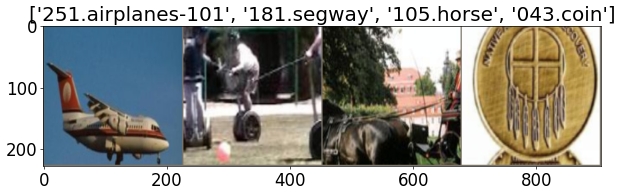

In [7]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})
def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()# load a batch of train image
iterator = iter(train_dataloader)# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

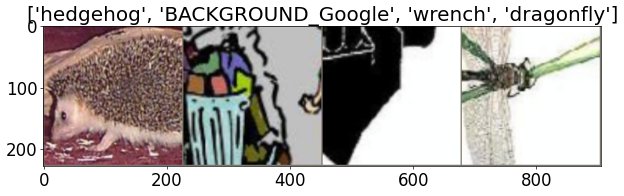

In [8]:
iterator = iter(new_train_dataloader)# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names_new[x] for x in classes[:4]])

In [9]:
model = models.alexnet(weights = AlexNet_Weights.IMAGENET1K_V1)  
# Freeze all the pre-trained layers
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(*[model.classifier[i] for i in range(5)])
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [10]:
features = []
f_labels = []

for i, data in enumerate(train_dataloader):
    image, labels = data
    image = image.to(device)
    labels = labels.to(device)
    
    batch_features = model(image)
    
    for j in range(image.size()[0]):
        features.append(batch_features[j].cpu().numpy())
        f_labels.append(labels[j].cpu().numpy())

print(len(features))   

27552


In [11]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=12)
knn.fit(features, f_labels)

KNeighborsClassifier(n_neighbors=12)

In [12]:
from sklearn.metrics import accuracy_score

test_features = []
test_labels = []

for i, data in enumerate(test_dataloader):
    image, labels = data
    image = image.to(device)
    labels = labels.to(device)
    
    batch_features = model(image)
    
    for j in range(image.size()[0]):
        test_features.append(batch_features[j].cpu().numpy())
        test_labels.append(labels[j].cpu().numpy())

pred = knn.predict(test_features)
accuracy = accuracy_score(test_labels, pred)
print("Knn test accuracy:", accuracy)

Knn test accuracy: 0.40137165251469625


In [13]:
for i, data in enumerate(new_train_dataloader):
    image, labels = data
    image = image.to(device)
    labels = labels.to(device)
    
    batch_features = model(image)
    
    for j in range(image.size()[0]):
        features.append(batch_features[j].cpu().numpy())
        f_labels.append(labels[j].cpu().numpy())

print(len(features))   
knn.fit(features, f_labels)

30847


KNeighborsClassifier(n_neighbors=12)

In [14]:
for i, data in enumerate(new_test_dataloader):
    image, labels = data
    image = image.to(device)
    labels = labels.to(device)
    
    batch_features = model(image)
    
    for j in range(image.size()[0]):
        test_features.append(batch_features[j].cpu().numpy())
        test_labels.append(labels[j].cpu().numpy())

pred = knn.predict(test_features)
accuracy = accuracy_score(test_labels, pred)
print("Knn test accuracy:", accuracy)

Knn test accuracy: 0.3794109069699621
